In [1]:
# import standard python libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from coolpuppy.lib import io

In [2]:
os.chdir("/exports/igmm/eddie/wendy-lab/elias/Friman2022/contact_screen")

In [3]:
pup_data = io.load_pileup_df("/exports/igmm/eddie/wendy-lab/elias/Friman2022/pileups/Hsieh_mESCs_microC.mm10.mapq_30.1000_mm10-cCREs_ESC_DNase_merged5kb_mm10.bed_expected_noflank_10kbres_100kbto10Mb_stripe.clpy")

In [4]:
pup_data = pup_data[pup_data["separation"] != "all"]

In [5]:
contact_freq = pd.DataFrame({"chrom": [item[0] for sublist in pup_data["coordinates"] for item in sublist],
                             "start1": [int(item[1]) for sublist in pup_data["coordinates"] for item in sublist],
                             "end1": [int(item[2]) for sublist in pup_data["coordinates"] for item in sublist],
                             "start2": [int(item[4]) for sublist in pup_data["coordinates"] for item in sublist],
                             "end2": [int(item[5]) for sublist in pup_data["coordinates"] for item in sublist],
                             "distance_band": ''.join([str(item)*pup_data.loc[pup_data["distance_band"] == item, "vertical_stripe"].reset_index(drop=True)[0].shape[0] for item in pup_data["distance_band"]]).split(")("),                    
                             "contact": [item[0] for sublist in pup_data["vertical_stripe"] for item in sublist]})

In [6]:
contact_freq["distance_band"] = contact_freq["distance_band"].str.replace('(','', regex=False)
contact_freq["distance_band"] = contact_freq["distance_band"].str.replace(')','', regex=False)
contact_freq["coord1"] = contact_freq["chrom"] + "_" + contact_freq["start1"].astype(str) + "_" + contact_freq["end1"].astype(str)
contact_freq["coord2"] = contact_freq["chrom"] + "_" + contact_freq["start2"].astype(str) + "_" + contact_freq["end2"].astype(str)
contact_freq = contact_freq.dropna()

In [7]:
contact_freq["log2_contact"] = np.log2(contact_freq["contact"]+1)

In [8]:
cistrome_remap = pd.read_csv("/exports/igmm/eddie/wendy-lab/elias/Friman2022/Peaks/mm10/CRE/mm10-cCREs_ESC_DNase_merged5kb_mm10_cistromeDB_ReMap2020_filtered.bed", 
                             sep="\t", 
                             dtype={"chrom_cres": str, "start_cres": int, 
                                    "end_cres": int, "ID": str})

In [9]:
n_overlap_1 = pd.DataFrame(cistrome_remap.groupby(["coords_cre", "Factor"]).size().groupby("coords_cre").size()).reset_index()
n_overlap_1.columns = ["coord1", "n_overlap_1"]
n_overlap_2 = pd.DataFrame(cistrome_remap.groupby(["coords_cre", "Factor"]).size().groupby("coords_cre").size()).reset_index()
n_overlap_2.columns = ["coord2", "n_overlap_2"]
n_overlap = pd.concat([n_overlap_1, n_overlap_2], axis=1)

In [10]:
overlaps_short = pd.merge(pd.merge(contact_freq.loc[contact_freq["distance_band"] == "100000, 1000000"], n_overlap_1), n_overlap_2)
overlaps_short["n_overlap"] = overlaps_short["n_overlap_1"] + overlaps_short["n_overlap_2"]

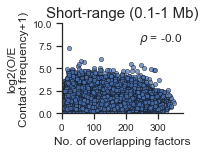

In [14]:
cm = 1/2.54
sns.set(style="ticks", font="Arial")
sns.set_context("notebook", rc={"font.size":1,"axes.titlesize":15, 
                                "axes.labelsize":12, "xtick.labelsize": 10,
                                "ytick.labelsize": 10})  
plt.figure(figsize=(6*cm,5*cm))
r, pvalue = scipy.stats.spearmanr(overlaps_short["n_overlap"], overlaps_short["log2_contact"])
g = sns.scatterplot(data = overlaps_short, x="n_overlap", y="log2_contact",
                    alpha=0.7, s=20, edgecolor='black', linewidth = 0.5)
g.set(xlabel="No. of overlapping factors",
      ylabel="log2(O/E\nContact frequency+1)",
      title="Short-range (0.1-1 Mb)",
      xlim=[0, 380],
      ylim=[0, 10])
sns.despine()
g.text(240, 8, str(r'$\rho$' + f' = {r:.1f}'), 
       horizontalalignment='left',
       fontsize=12)
plt.tight_layout()
plt.savefig("plots/mESC_shortrange_nrpeaks_corr.png", dpi=300, bbox_inches='tight')

In [15]:
overlaps_long = pd.merge(pd.merge(contact_freq.loc[contact_freq["distance_band"] == "1000000, 10000000"], n_overlap_1), n_overlap_2)
overlaps_long["n_overlap"] = overlaps_long["n_overlap_1"] + overlaps_long["n_overlap_2"]

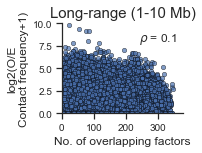

In [16]:
cm = 1/2.54
sns.set(style="ticks", font="Arial")
sns.set_context("notebook", rc={"font.size":1,"axes.titlesize":15, 
                                "axes.labelsize":12, "xtick.labelsize": 10,
                                "ytick.labelsize": 10})  
plt.figure(figsize=(6*cm,5*cm))
r, pvalue = scipy.stats.spearmanr(overlaps_long["n_overlap"], overlaps_long["log2_contact"])
g = sns.scatterplot(data = overlaps_long, x="n_overlap", y="log2_contact",
                    alpha=0.7, s=20, edgecolor='black', linewidth = 0.5)
g.set(xlabel="No. of overlapping factors",
      ylabel="log2(O/E\nContact frequency+1)",
      title="Long-range (1-10 Mb)",
      xlim=[0, 380],
      ylim=[0, 10])
sns.despine()
g.text(240, 8, str(r'$\rho$' + f' = {r:.1f}'), 
       horizontalalignment='left',
       fontsize=12)
plt.tight_layout()
plt.savefig("plots/mESC_longrange_nrpeaks_corr.png", dpi=300, bbox_inches='tight')